In [1]:
import os
os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

import dLux as dl
import matplotlib.pyplot as plt
import dLuxToliman as dlT
from matplotlib import colors
from jax import numpy as np

from detector_layers import ApplyJitter
from dLux.detector_layers import DetectorLayer
from jax import Array
from jax.scipy.stats import multivariate_normal

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "monospace"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

In [36]:
pscale = .375  # arcsec/pixel
det_npix = 128
oversample = 4
wf_npixels = 512
kernel_size = 20
jitter_params = {"r": 0.1, "phi": 45, "shear": 0}

In [1]:
src = dlT.AlphaCen()
osys = dlT.TolimanOptics(wf_npixels=512, psf_pixel_scale=pscale, psf_oversample=oversample, psf_npixels=det_npix*oversample)
det = dl.LayeredDetector([
    (ApplyJitter(**jitter_params, kernel_size=kernel_size), 'Jitter'),
    (dl.IntegerDownsample(oversample), 'Downsample'),
])

tel = dl.Instrument(sources=src, optics=osys, detector=det)

NameError: name 'dlT' is not defined

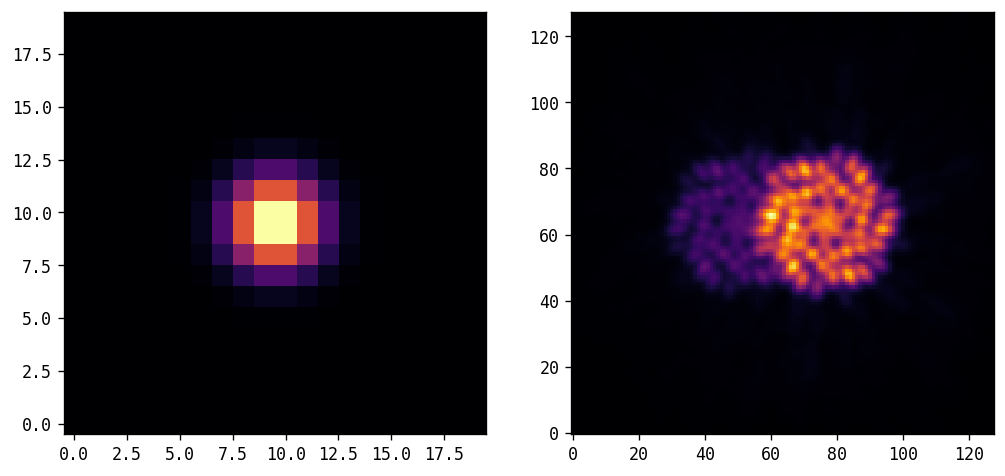

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(det.Jitter.generate_kernel(pscale))
ax[1].imshow(tel.model())
plt.show()

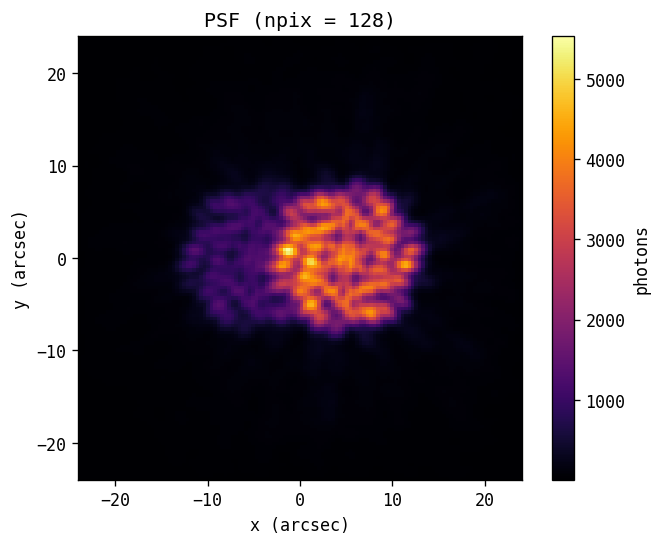

In [7]:
PSF = tel.model()

l = PSF.shape[0] / 2
fig, ax = plt.subplots()
im = ax.imshow(PSF,
               cmap='inferno',
               # norm=colors.PowerNorm(gamma=0.5),
               extent=pscale*np.array([-l, l, -l, l]),
               )
fig.colorbar(im, ax=ax, label='photons')
ax.set(title='PSF (npix = {})'.format(det_npix),
        xlabel='x (arcsec)',
        ylabel='y (arcsec)',
        )
plt.show()